# Expanding window features

In this notebook, we demonstrate how to compute expanding window features using Pandas and Feature-engine.



## Data set synopsis


We will work with the hourly electricity demand dataset. It is the electricity demand for the state of Victora in Australia from 2002 to the start of 2015. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context("talk")

# Load data

In [13]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)

In [14]:
# For this demo we will use a subset of the data.
data = data.loc["2010":]

In [15]:
data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,8314.448682,21.525
2010-01-01 01:00:00,8267.187296,22.400
2010-01-01 02:00:00,7394.528444,22.150
2010-01-01 03:00:00,6952.047520,21.800
2010-01-01 04:00:00,6867.199634,20.250


# Computing expanding windows features using Pandas

In [16]:
# Create a copy of the data.
df = data.copy()

We want to compute the expanding:
- mean
- standard deviation
- median absolute deviation

The median absolute deviation is not implemented natively in Pandas so we have to create our own functions to calculate these statistics. Let's create a function to compute the median absolute deviation which is defined as: $MAD = median(|x_i - median(x)|)$

In [17]:
# Create a custom metric for the MAD
def mad(x):
    return np.median(np.abs(x - np.median(x)))

Let's compute the expanding window features!

In [18]:
result = (
    df["demand"]
    .expanding()  # Use `expanding` rather than `rolling`.
    .agg(["mean", "std", mad]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("demand_expanding_window_")

result

,demand_expanding_window_mean,demand_expanding_window_std,demand_expanding_window_mad
date_time,,,
2010-01-01 01:00:00,8314.448682,NaN,0.000000
2010-01-01 02:00:00,8290.817989,33.418847,23.630693
2010-01-01 03:00:00,7992.054807,518.012283,47.261386
2010-01-01 04:00:00,7732.052986,670.294667,459.960119
2010-01-01 05:00:00,7559.082315,697.542450,527.328810
...,...,...,...
2015-02-28 20:00:00,9463.656071,1752.022191,1307.193992
2015-02-28 21:00:00,9463.643240,1752.004951,1307.102152
2015-02-28 22:00:00,9463.617965,1751.993833,1307.081377


Let's join this back to the original dataframe.

In [19]:
df = df.join(result, how="left")
df

,demand,temperature,demand_expanding_window_mean,demand_expanding_window_std,demand_expanding_window_mad
date_time,,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,8314.448682,NaN,0.000000
2010-01-01 02:00:00,7394.528444,22.150,8290.817989,33.418847,23.630693
2010-01-01 03:00:00,6952.047520,21.800,7992.054807,518.012283,47.261386
2010-01-01 04:00:00,6867.199634,20.250,7732.052986,670.294667,459.960119
...,...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9463.653128,1752.041445,1307.141316
2015-02-28 20:00:00,8883.230296,22.200,9463.656071,1752.022191,1307.193992
2015-02-28 21:00:00,8320.260550,18.900,9463.643240,1752.004951,1307.102152


# Using Feature-engine

Let's see how we can extract window features using the Feature-engine library.

In [20]:
from feature_engine.timeseries.forecasting import ExpandingWindowFeatures

In [21]:
# Create a copy of the data.
df = data.copy()

In [23]:
# Create window features using the transformer.
transformer = ExpandingWindowFeatures(
    variables=["demand", "temperature"], 
    functions=["mean", "std"], 
    freq="1H" # Shift results back by 1 hour to avoid data leakage.
)  

df = transformer.fit_transform(df)
df

,demand,temperature,demand_expanding_mean,demand_expanding_std,temperature_expanding_mean,temperature_expanding_std
date_time,,,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,8314.448682,NaN,21.525000,NaN
2010-01-01 02:00:00,7394.528444,22.150,8290.817989,33.418847,21.962500,0.618718
2010-01-01 03:00:00,6952.047520,21.800,7992.054807,518.012283,22.025000,0.450694
2010-01-01 04:00:00,6867.199634,20.250,7732.052986,670.294667,21.968750,0.384802
...,...,...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9463.653128,1752.041445,16.277680,5.616737
2015-02-28 20:00:00,8883.230296,22.200,9463.656071,1752.022191,16.277947,5.616962
2015-02-28 21:00:00,8320.260550,18.900,9463.643240,1752.004951,16.278078,5.616969


Let's look at the expanding window mean of the demand.

Text(0.5, 0, 'Time')

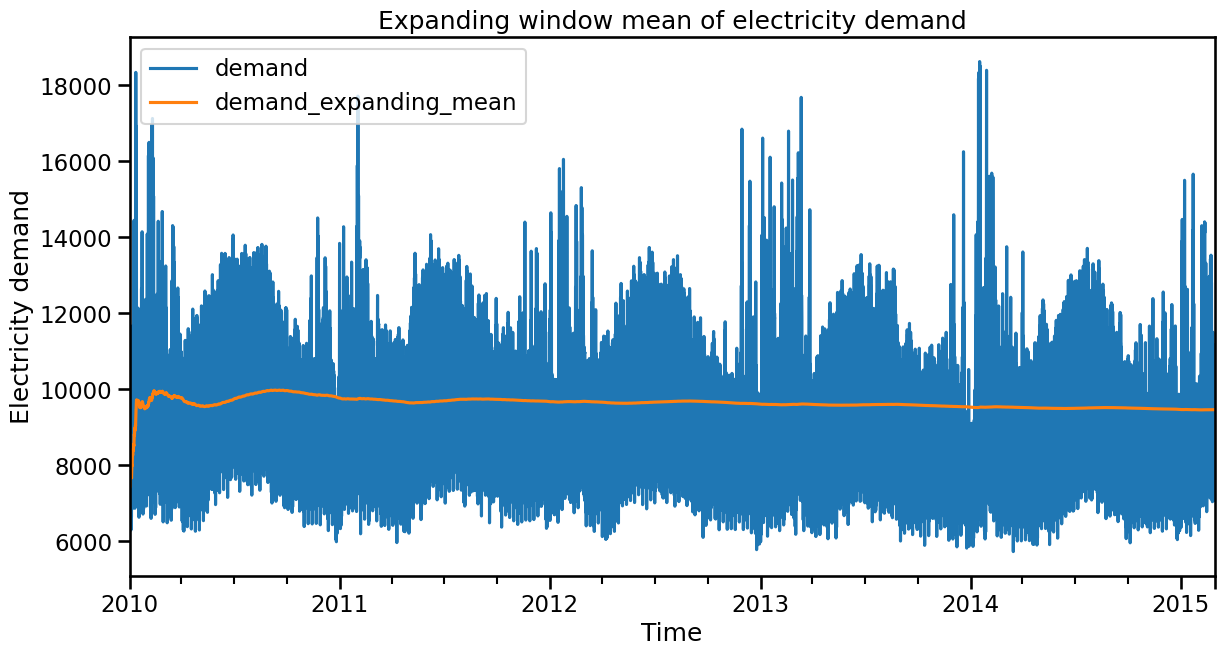

In [24]:
ax = df.loc[:, ["demand", "demand_expanding_mean"]].plot(figsize=[14, 7])
ax.set_title("Expanding window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("Time")

We can see that the expanding mean is more volatile at the start when there is less data but it then quickly stabilises as the window gets larger and larger.

In practice, expanding windows are used less often than rolling windows because the most recent time periods tend to be more useful for forecasting. Exponential weights are normally combined with expanding windows to give more weight to recent data. We'll explore this in notebook 4.

This demonstrates how we can compute expanding window statistics using different libraries. 